In [1]:
from datetime import datetime
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)
plt.style.use("dark_background")

In [2]:
from heston import infer_heston_parameters, Heston, GeometricBrownianMotion
from get_observed import get_samples

In [3]:
STOCK_NAMES = ["AMZN", "GOOGL", "MSFT"]
PREDICITON_PERIOD = 3 * 20
INTERVAL = "1d"

STRIKE = 1.0
KNOCKIN_LEVEL = .8
KNOCKOUT_LEVEL = 1.0

NUM_COUPON_DATES = 4
NUM_KNOCKOUT_DATES = 4

COUPON = .095 * NUM_COUPON_DATES * PREDICITON_PERIOD / 20 * 30 / 360
NOTIONAL = 1000

START = datetime(2010, 1, 1)
END = datetime(2020, 1, 1)

LOCAL_WINDOW_SIZE = 5
DT = 1

NUM_SIMULATIONS = 64
NUM_SAMPLES = 1000
NUM_PLOTS = 5
NUM_DATAPOINTS = 16

In [4]:
def get_heston_predictions(actual_samples):

    data = []

    for observed_processes in actual_samples:
        
        heston_parameters = infer_heston_parameters(observed_processes)
        gbm_parameters = {"mu": heston_parameters["rs"], "sigma": np.sqrt(heston_parameters["thetas"]), "lambdas": heston_parameters["lambdas"]}

        heston = Heston(**heston_parameters)
        heston_sde_predictions = heston.predict(observed_processes, num_simulations=NUM_SIMULATIONS, dt=DT)

        gbm = GeometricBrownianMotion(**gbm_parameters)
        gbm_sde_predictions = gbm.predict(observed_processes, num_simulations=NUM_SIMULATIONS, dt=DT)

        index = observed_processes[0].index

        actual = {}
        heston_predictions = []
        gbm_predictions = []
        for k in range(NUM_SIMULATIONS):
            heston_prediction = {}
            gbm_prediction = {}
            for j, stock_name in enumerate(STOCK_NAMES):
                heston_prediction[stock_name] = heston_sde_predictions[:, k, 2 * j]
                gbm_prediction[stock_name] = gbm_sde_predictions[:, k, j]
                if k == 0:
                    actual[stock_name] = observed_processes[j]["S"]
            heston_predictions.append(pd.DataFrame(heston_prediction, index=index))
            gbm_predictions.append(pd.DataFrame(gbm_prediction, index=index))
        actual = pd.DataFrame(actual, index=index)
        
        data.append({"actual": actual, "heston": heston_predictions, "gbm": gbm_predictions, "heston_parameters": heston_parameters, "gbm_parameters": gbm_parameters})
    
    return data
    
    

In [5]:
def plot(trajectory):

    fig, axs = plt.subplots(1, 2)
    fig.set_figheight(4)
    fig.set_figwidth(12)

    actual = trajectory["actual"]

    stock_name = STOCK_NAMES[0]

    for k, method in enumerate(["heston", "gbm"]):
        
        predictions = trajectory[method]
        parameters = trajectory[method + "_parameters"]
        
        axs[k].plot(actual.index, actual[stock_name], c="purple", linewidth=3, alpha=1)
        for prediction in predictions[:NUM_DATAPOINTS]:
            axs[k].plot(prediction.index, prediction[stock_name], c="red", linewidth=1, alpha=.7)
        axs[k].set_xticks([])
    
        title_string = ", ".join([f"$\\{p.rstrip('s')}=${parameters[p][0]:.2g}" for p in parameters if p not in ("lambdas", "rs")])
        axs[k].set_title(f"{method.upper()}: {title_string}")

    plt.show()

In [6]:
actual_samples = get_samples(STOCK_NAMES, NUM_SAMPLES, START, END, INTERVAL, LOCAL_WINDOW_SIZE, PREDICITON_PERIOD)
trajectories = get_heston_predictions(actual_samples)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


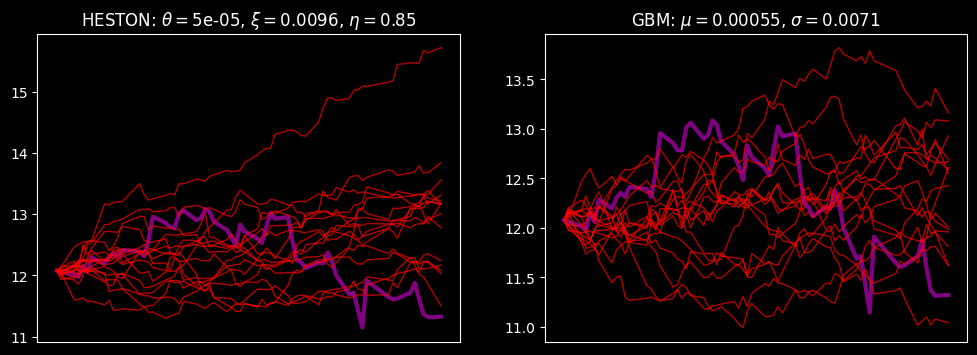

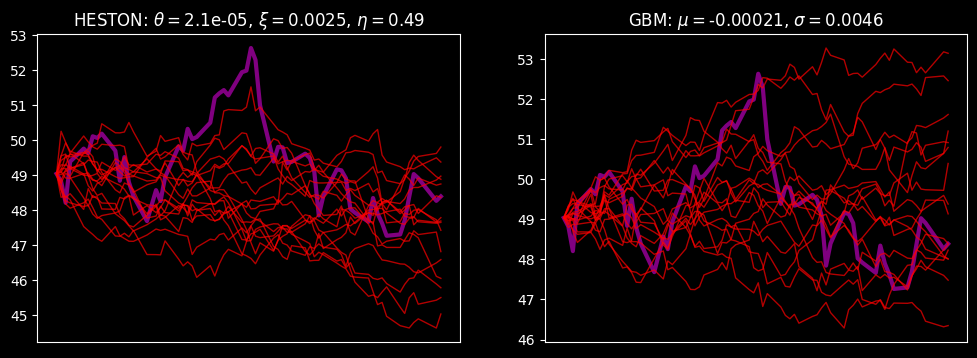

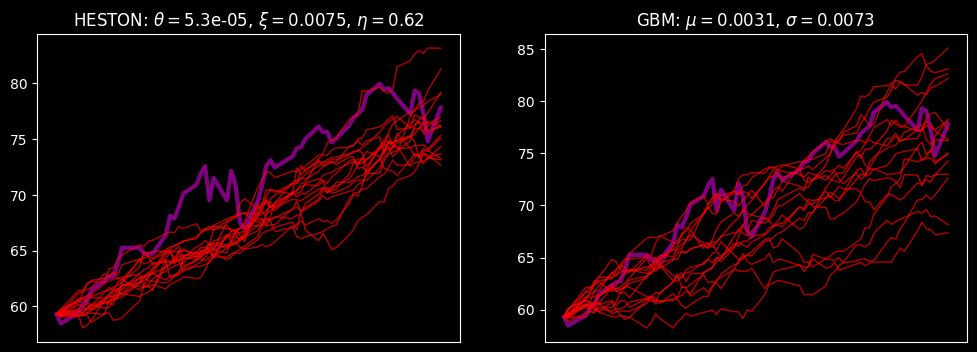

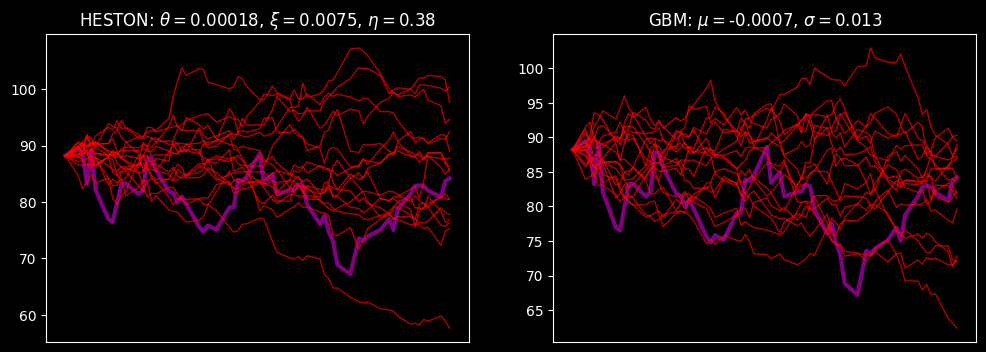

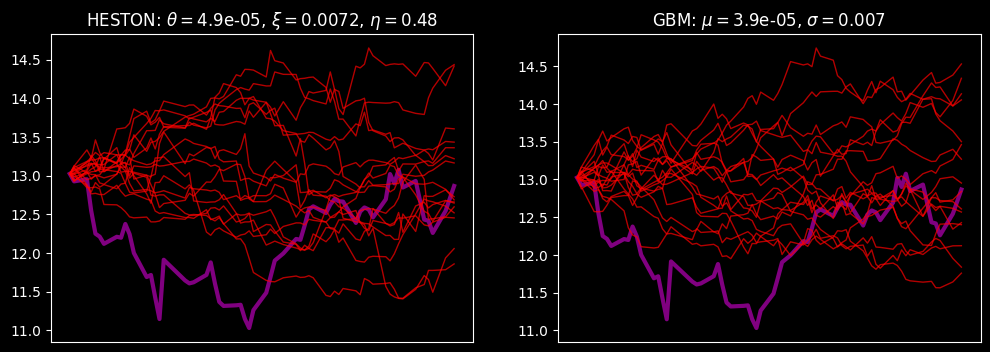

In [7]:
for trajectory in trajectories[:NUM_PLOTS]:
    plot(trajectory)

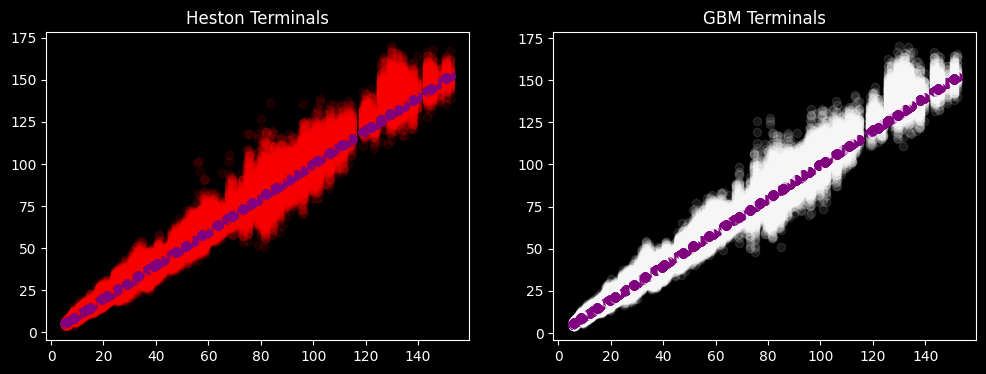

In [8]:
actual_terminals, predicted_terminals = dict(), dict()
fig, axs = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(12)

axs[0].set_title("Heston Terminals")
axs[1].set_title("GBM Terminals")

for trajectory in trajectories:
    actual, heston, gbm = trajectory["actual"], trajectory["heston"], trajectory["gbm"]
    heston_terminals = np.array([prediction.iloc[-1] for prediction in heston])
    gbm_terminals = np.array([prediction.iloc[-1] for prediction in gbm])
    actual_terminals = [actual.iloc[-1]] * len(heston_terminals)
    axs[0].scatter(actual_terminals, heston_terminals, color="red", alpha=.1)
    axs[0].scatter(actual_terminals, actual_terminals, color="purple")
    axs[1].scatter(actual_terminals, gbm_terminals, color="white", alpha=.1)
    axs[1].scatter(actual_terminals, actual_terminals, color="purple")

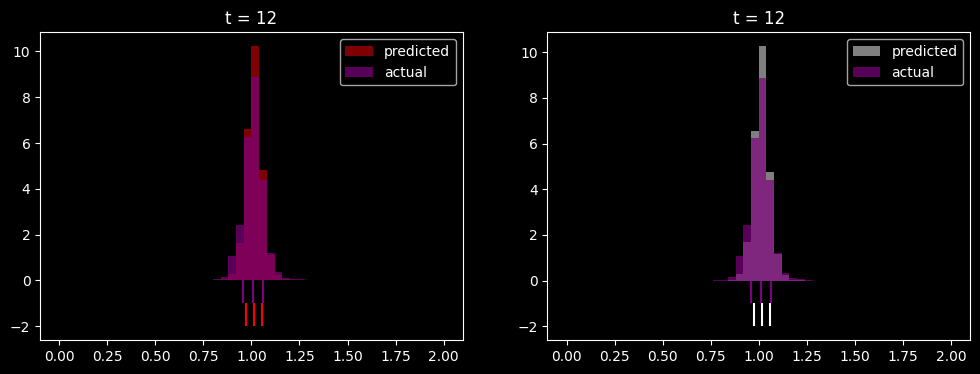

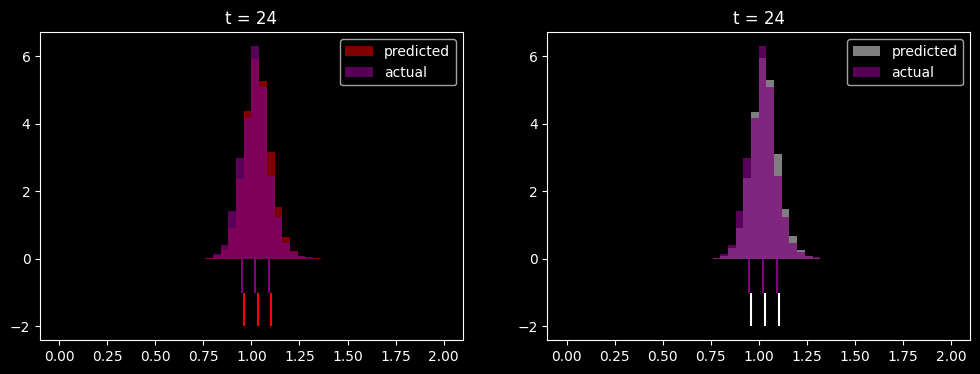

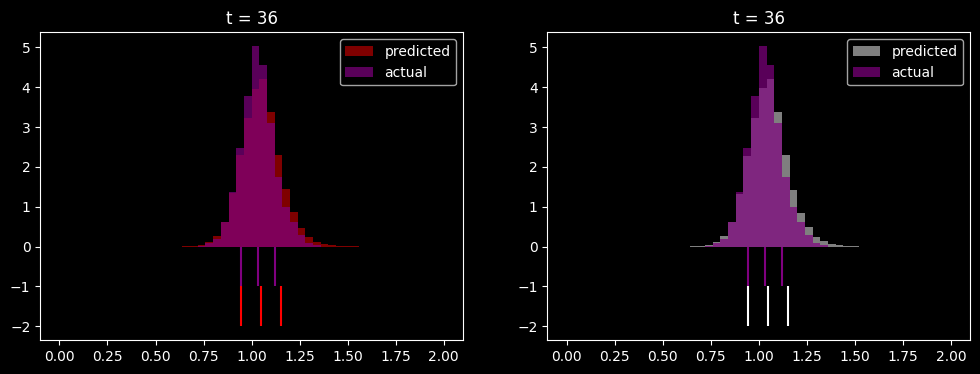

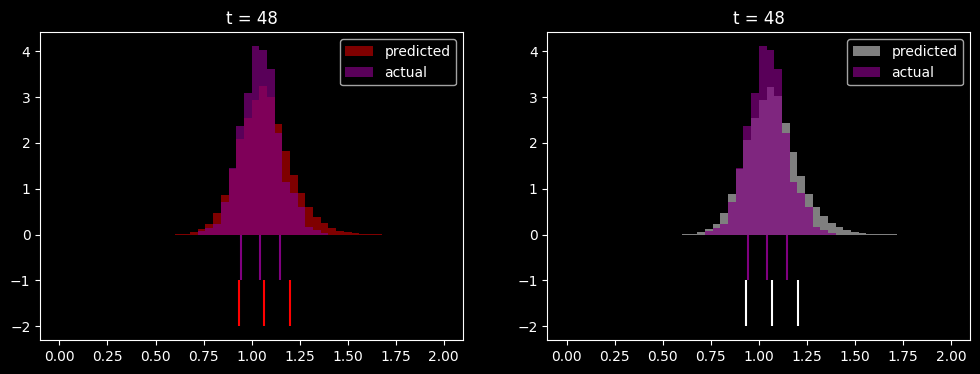

In [9]:
actual_distribution, heston_distribution, gbm_distribution = defaultdict(list), defaultdict(list), defaultdict(list)
time_range = range(PREDICITON_PERIOD // 5, PREDICITON_PERIOD, PREDICITON_PERIOD // 5)
colors = ["red", "white"]

for trajectory in trajectories:
    actual, heston, gbm = trajectory["actual"], trajectory["heston"], trajectory["gbm"]
    for t in time_range:
        for stock_name in STOCK_NAMES:
            actual_distribution[t].append(actual[stock_name].iloc[t] / actual[stock_name].iloc[0])
            for heston_prediction in trajectory["heston"]:
                heston_distribution[t].append(heston_prediction[stock_name].iloc[t] / heston_prediction[stock_name].iloc[0])
            for gbm_prediction in trajectory["gbm"]:
                gbm_distribution[t].append(gbm_prediction[stock_name].iloc[t] / gbm_prediction[stock_name].iloc[0])


def vlines(distribution):
    mean = np.mean(distribution)
    std = np.std(distribution)
    return [mean - std, mean, mean + std]


for t in time_range:
    fig, axs = plt.subplots(1, 2)
    fig.set_figheight(4)
    fig.set_figwidth(12)
    for i, distribution in enumerate([heston_distribution, gbm_distribution]):
        axs[i].hist(distribution[t], range=(0, 2), bins=50, histtype="stepfilled", density=True, color=colors[i], alpha=.5, label="predicted")
        axs[i].vlines(vlines(distribution[t]), ymin=-2, ymax=-1, color=colors[i])
        axs[i].hist(actual_distribution[t], range=(0, 2), bins=50, histtype="stepfilled", density=True, color="purple", alpha=.7, label="actual")
        axs[i].vlines(vlines(actual_distribution[t]), ymin=-1, ymax=0, color="purple")
        axs[i].set_title(f"t = {t}")
        axs[i].legend()
    plt.show()

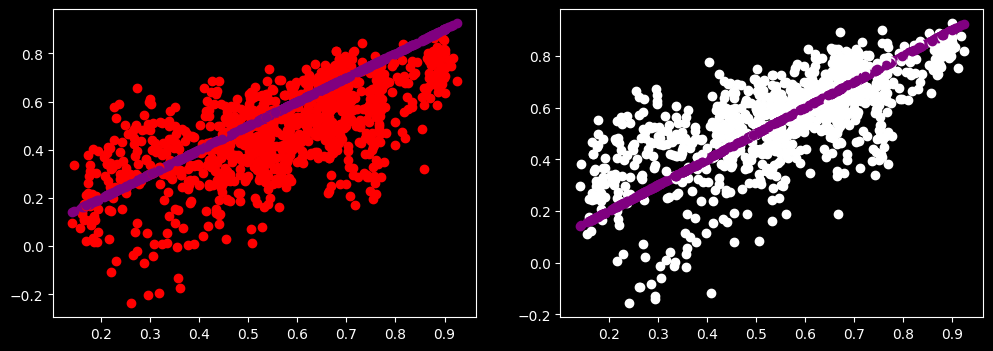

In [10]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(12)


def get_noise(a, rs, time_deltas, vol):
    return (a[1:] - a[:-1] - rs * a[:-1] * time_deltas) / (a[:-1] * np.sqrt(vol.mean() * time_deltas))


for trajectory, sample in zip(trajectories, actual_samples):

    actual_noises, heston_noises, gbm_noises = [], [], []
    
    for j, stock_name in enumerate(STOCK_NAMES):
    
        time_deltas = np.array(sample[j]["_time_deltas"])[:-1]
        rs = np.array(sample[j]["r"])[:-1]
        vol = np.array(sample[j]["ν"])[:-1]
        
        actual_noise = get_noise(np.array(trajectory["actual"][stock_name]), rs, time_deltas, vol)
        heston_noise = get_noise(np.array(trajectory["heston"][0][stock_name]), rs, time_deltas, vol)
        gbm_noise = get_noise(np.array(trajectory["gbm"][0][stock_name]), rs, time_deltas, vol)
    
        actual_noises.append(actual_noise), heston_noises.append(heston_noise), gbm_noises.append(gbm_noise)
    
    actual_cov = np.corrcoef(actual_noises)
    heston_cov = np.corrcoef(heston_noises)
    gbm_cov = np.corrcoef(gbm_noises)
    
    axs[0].scatter(actual_cov[0, 1], heston_cov[0, 1], color="red")
    axs[0].scatter(actual_cov[0, 1], actual_cov[0, 1], color="purple")
    axs[1].scatter(actual_cov[0, 1], gbm_cov[0, 1], color="white")
    axs[1].scatter(actual_cov[0, 1], actual_cov[0, 1], color="purple")

plt.show()

In [11]:
def autocallable_payoff(price_df):
    
    dates = price_df.index
    initial_prices = price_df.iloc[0]
    knockin_barriers = KNOCKIN_LEVEL * initial_prices
    knockout_barriers = KNOCKOUT_LEVEL * initial_prices
    
    coupon_date_indices = range(-1, -len(dates), -len(dates) // NUM_COUPON_DATES)
    assert len(coupon_date_indices) == NUM_COUPON_DATES
    coupon_dates = dates[coupon_date_indices]
    
    knockout_date_indices = range(-1, -len(dates), -len(dates) // NUM_KNOCKOUT_DATES)
    assert len(knockout_date_indices) == NUM_KNOCKOUT_DATES
    knockout_dates = dates[knockout_date_indices]

    knock_in = False
    coupon_payoff = .0

    for date, prices in price_df.iterrows():
        if (prices <= knockin_barriers).any():
            knock_in = True
        if date in coupon_dates:
            coupon_payoff += NOTIONAL * COUPON
        if date in knockout_dates and (prices >= knockout_barriers).all():
            return NOTIONAL + coupon_payoff
    
    if knock_in:
        knock_in_factor = min(1, (prices / (STRIKE * initial_prices)).min())
        final_payoff = knock_in_factor * NOTIONAL
    else:
        final_payoff = NOTIONAL
    return final_payoff + coupon_payoff

In [12]:
actual_payoffs = []
heston_payoffs = []
gbm_payoffs = []

for trajectory in tqdm(trajectories):

    actual_path = trajectory["actual"]
    heston_paths = trajectory["heston"]
    gbm_paths = trajectory["gbm"]

    heston_payoffs.extend([autocallable_payoff(heston_path) for heston_path in heston_paths])
    gbm_payoffs.extend([autocallable_payoff(gbm_path) for gbm_path in gbm_paths])
    actual_payoffs.extend([autocallable_payoff(actual_path)] * len(heston_paths))

actual_payoffs, heston_payoffs, gbm_payoffs = map(np.array, [actual_payoffs, heston_payoffs, gbm_payoffs])

gbm_differences = actual_payoffs - gbm_payoffs
heston_differences = actual_payoffs - heston_payoffs


100%|██████████| 1000/1000 [03:01<00:00,  5.51it/s]


In [13]:
gbm_label = f"GBM. MAE={np.mean(np.abs(gbm_differences)):.2f}, VaR={np.percentile(gbm_payoffs):.2f}"
plt.hist(gbm_differences, alpha=.5, range=(-100, 100), label=gbm_label, color="white")
heston_label = f"Heston. MAE={np.mean(np.abs(heston_differences)):.2f}, VaR={np.percentile(heston_payoffs):.2f}"
plt.hist(heston_differences, alpha=.3, range=(-100, 100), label=heston_label, color="red")
plt.legend()
plt.show()

TypeError: percentile() missing 1 required positional argument: 'q'

In [ ]:
argmaxes = np.argsort(np.abs(gbm_payoffs - heston_payoffs))
for argmax in argmaxes[-NUM_PLOTS:]:
    plot(trajectories[argmax // NUM_SIMULATIONS])